C:\Users\mpk25\AppData\Local\Temp\ipykernel_12664\2815478586.py:15: DeprecationWarning: Call to deprecated function stored_results. Reason: The property counterpart 'stored_results' will be added in a future release, and this method will be removed.
  for result in cursor.stored_results():


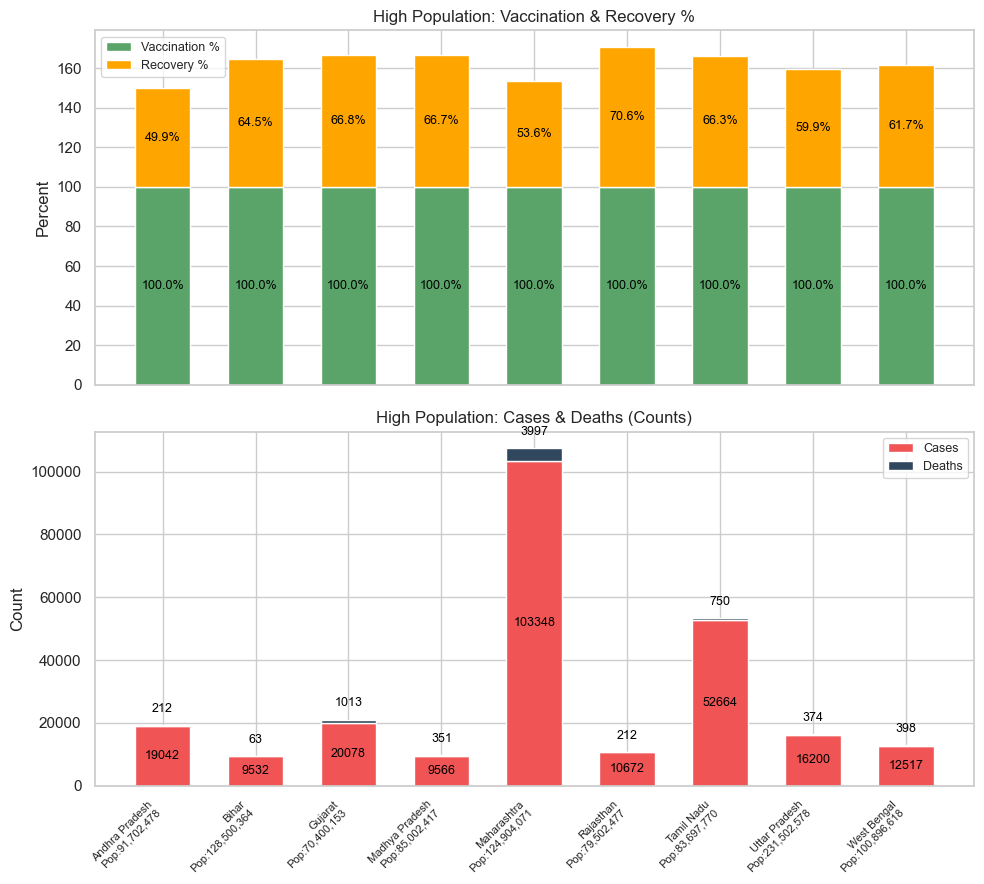

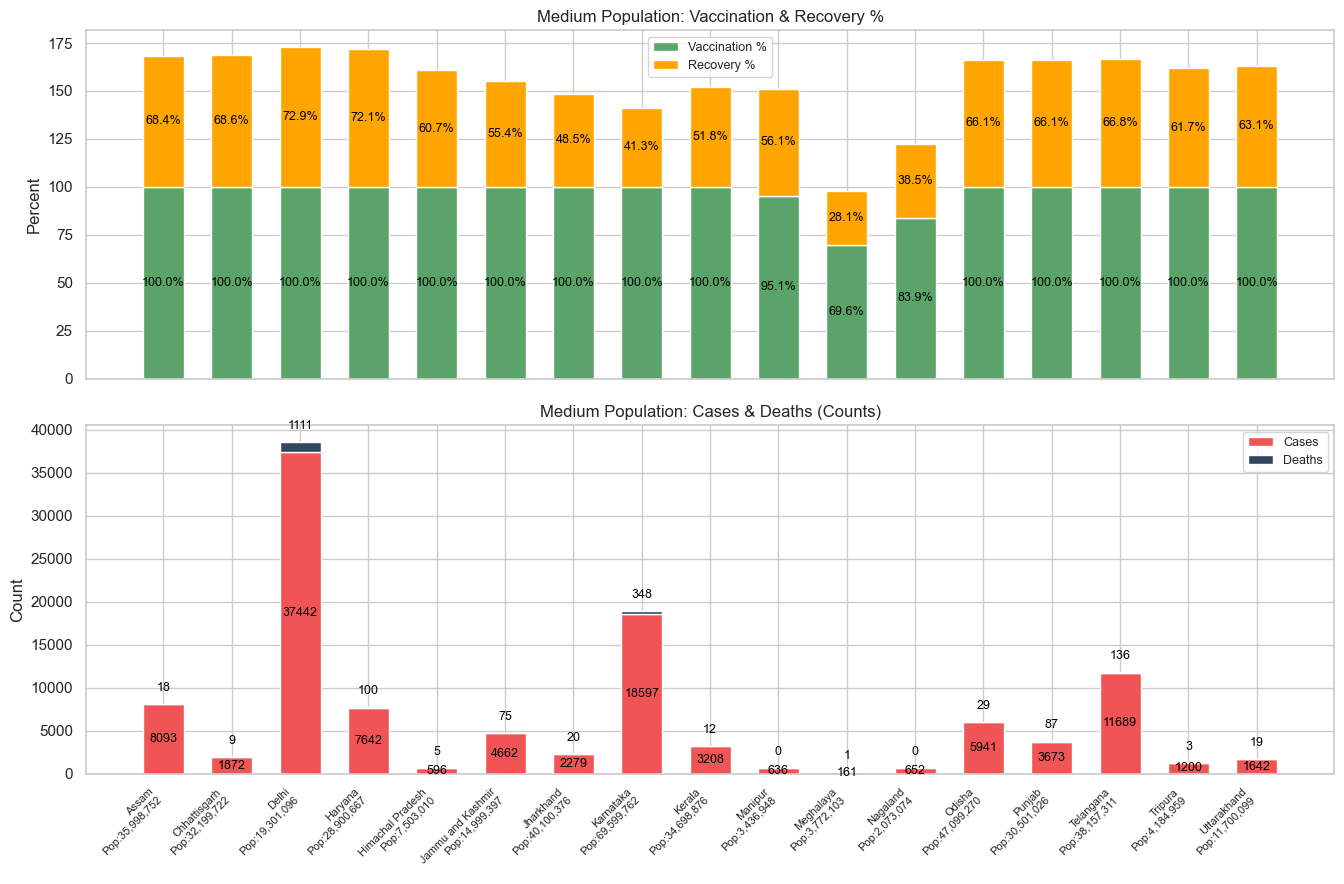

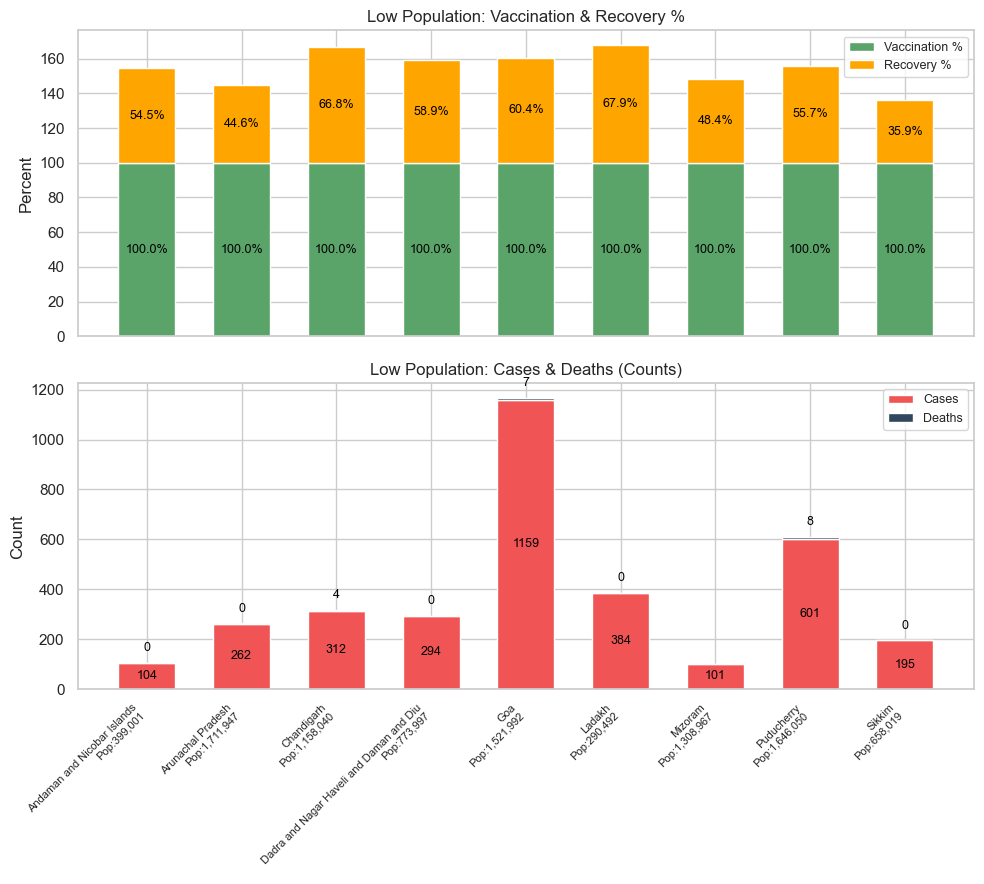

In [2]:
import mysql.connector
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Data fetch and preparation ---
conn = mysql.connector.connect(
    host="localhost",
    user="root",
    password="pravasya",
    database="dummy"
)
cursor = conn.cursor()
cursor.callproc('covid_full_summary_percent')
for result in cursor.stored_results():
    df = pd.DataFrame(result.fetchall(), columns=[i[0] for i in result.description])
cursor.close()
conn.close()

# Convert numerics (important for annotation + calculation)
for col in ['Vaccination_Percent', 'Recovery_Percent', 'Avg_Cases', 'Avg_Deaths', 'Population']:
    df[col] = df[col].astype(float)

high_thresh = df['Population'].quantile(0.75)
low_thresh = df['Population'].quantile(0.25)

def pop_category(pop):
    if pop >= high_thresh:
        return 'High'
    elif pop <= low_thresh:
        return 'Low'
    else:
        return 'Medium'

df['Population_Category'] = df['Population'].apply(pop_category)
df['Vaccination_Percent'] = df['Vaccination_Percent'].clip(upper=100)
df['Recovery_Percent'] = df['Recovery_Percent']

df_high = df[df['Population_Category'] == 'High'].sort_values('State_UT')
df_medium = df[df['Population_Category'] == 'Medium'].sort_values('State_UT')
df_low = df[df['Population_Category'] == 'Low'].sort_values('State_UT')

sns.set(style="whitegrid", context="notebook")
vacc_color = "#5AA469"
recov_color = "#FFA500"
cases_color = "#F05454"
deaths_color = "#30475E"

groupings = [
    ('High', df_high),
    ('Medium', df_medium),
    ('Low', df_low),
]

for group, df_cat in groupings:
    x = range(len(df_cat))
    pop_labels = [f"{state}\nPop:{int(pop):,}" for state, pop in zip(df_cat['State_UT'], df_cat['Population'])]
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(max(10, len(df_cat) * 0.8), 9), sharex=True)

    # --- Vaccination & Recovery (Percent) ---
    vacc_vals = df_cat['Vaccination_Percent'].values
    recov_vals = df_cat['Recovery_Percent'].values
    ax1.bar(x, vacc_vals, width=0.6, color=vacc_color, label='Vaccination %')
    ax1.bar(x, recov_vals, width=0.6, bottom=vacc_vals, color=recov_color, label='Recovery %')
    for i, (v, r) in enumerate(zip(vacc_vals, recov_vals)):
        ax1.text(i, v / 2, f"{v:.1f}%", ha='center', va='center', fontsize=9, color='black')
        ax1.text(i, v + r / 2, f"{r:.1f}%", ha='center', va='center', fontsize=9, color='black')
    ax1.set_ylabel('Percent')
    ax1.set_title(f"{group} Population: Vaccination & Recovery %")
    ax1.legend(fontsize=9)

    # --- Cases & Deaths (Counts) ---
    cases_vals = df_cat['Avg_Cases'].values
    deaths_vals = df_cat['Avg_Deaths'].values
    offset = max(cases_vals.max() + deaths_vals.max(), 1) * 0.03  # 3% of max bar for upward offset
    ax2.bar(x, cases_vals, width=0.6, color=cases_color, label='Cases')
    ax2.bar(x, deaths_vals, width=0.6, bottom=cases_vals, color=deaths_color, label='Deaths')
    for i, (c, d) in enumerate(zip(cases_vals, deaths_vals)):
        if c > 0:
            ax2.text(i, c / 2, f"{int(c)}", ha='center', va='center', fontsize=9, color='black')
        if d > 0:
            # deaths annotation moved upward by offset
            ax2.text(i, c + d + offset, f"{int(d)}", ha='center', va='bottom', fontsize=9, color='black')
    ax2.set_ylabel('Count')
    ax2.set_title(f"{group} Population: Cases & Deaths (Counts)")
    ax2.legend(fontsize=9)
    ax2.set_xticks(x)
    ax2.set_xticklabels(pop_labels, rotation=45, ha='right', fontsize=8)

    plt.tight_layout()
    plt.show()
